In [2]:
!pip install haversine

In [2]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
from itertools import zip_longest   # zip 함수 길이 다를 경우
from haversine import haversine

In [58]:
# 구의동
입지후보지 = pd.read_csv('입지선정후보군_좌표추가.csv', encoding='EUC-KR')
입지후보지 = 입지후보지[입지후보지['행정동'] == '구의제1동']
print(입지후보지.shape)
입지후보지.head(2)

(13, 6)


,분류,시설명,x좌표,y좌표,법정동,행정동
478,간이운동장,구의어린이공원,127.094743,37.536502,구의동,구의제1동
739,간이운동장,아차산배수지체육공원,127.096501,37.548963,구의동,구의제1동


In [59]:
버스 = pd.read_csv('서울시_버스정류장_행정동추가.csv')
버스 = 버스[버스['행정동'].isin(['구의1동', '화양동', '자양1동', '자양2동', '광장동', '중곡4동', '구의2동', '구의3동', '능동'])]
print(버스.shape)
버스.head(2)

(106, 7)


,정류소명,X좌표,Y좌표,정류버스수,행정동,행정동_경도,행정동_위도
273,광진구청,127.083386,37.538976,18,구의1동,127.084789,37.543188
304,어린이대공원역.화양천주교회,127.073693,37.546602,17,화양동,127.071368,37.546476


In [60]:
지하철 = pd.read_csv('서울시_지하철역_행정동추가.csv', encoding='EUC-KR', index_col=0)
지하철 = 지하철[지하철['행정동'].isin(['구의1동', '화양동', '자양1동', '자양2동', '광장동', '중곡4동', '구의2동', '구의3동', '능동'])]
print(지하철.shape)
지하철.head(2)

(5, 14)


,전철역코드,전철역명,전철명명(영문),호선,외부코드,검색키워드,주소,위도,경도,환승역,H/B,행정동,행정동_경도,행정동_위도
47,0214,강변역,Gangbyeon,2호선,214,강변역 2호선,서울 광진구 강변역로 53,37.535169,127.094665,0,H,구의3동,127.091961,37.537982
121,0213,구의역,Guui,2호선,213,구의역 2호선,서울 광진구 아차산로 384-1,37.537154,127.086179,0,H,자양2동,127.084415,37.528844


In [61]:
주차장 = pd.read_csv('서울시_주차장_행정동추가.csv', encoding='EUC-KR', index_col=0).drop('Unnamed: 0.1', axis=1)
주차장 = 주차장[주차장['행정동'].isin(['구의1동', '화양동', '자양1동', '자양2동', '광장동', '중곡4동', '구의2동', '구의3동', '능동'])]
print(주차장.shape)
주차장.head(2)

(15, 9)


,주차장id,주차장이름,주소,경도,위도,H/B,행정동,행정동_경도,행정동_위도
289,20589068,화양동 공영주차장,서울 광진구 화양동 63-2,127.071176,37.545298,H,화양동,127.071368,37.546476
291,20589328,능동공영주차장,서울 광진구 능동 205,127.080261,37.554043,H,능동,127.080537,37.553779


In [62]:
주택 = pd.read_csv('서울시주택_행정동추가.csv', encoding='EUC-KR', index_col=0).drop('Unnamed: 0.1', axis=1)
주택 = 주택[주택['행정동'].isin(['구의1동', '화양동', '자양1동', '자양2동', '광장동', '중곡4동', '구의2동', '구의3동', '능동'])]
print(주택.shape)
주택.head(2)

(3, 14)


,구명,단지명,주택유형,세대수,입주개시일,주소,우편번호,전화번호,경도,위도,H/B,행정동,행정동_경도,행정동_위도
117,광진구,한라녹턴,재건축,72,2009-09-11,영화사로16길 43 (구의동 구의동 아차산 한라아파트),4957,NaN,37.553835,127.097346,H,구의2동,127.089936,37.547246
118,광진구,래미안프리미어팰리스,재건축재개발,264,2017-11-01,아차산로 345(자양동 래미안프리미어팰리스아파트),5026,NaN,37.537505,127.081583,H,자양1동,127.082440,37.534507


In [63]:
버스_points = np.array([list(i) for i in zip(버스['X좌표'], 버스['Y좌표'])])
print(버스_points.shape)
버스_points[:2]

(106, 2)


array([[127.08338592,  37.53897619],
       [127.07369304,  37.54660224]])

In [64]:
지하철_points = np.array([list(i) for i in zip(지하철['경도'], 지하철['위도'])])
print(지하철_points.shape)
지하철_points[:2]

(5, 2)


array([[127.09466457,  37.53516928],
       [127.08617923,  37.53715356]])

In [65]:
주차장_points = np.array([list(i) for i in zip(주차장['경도'], 주차장['위도'])])
print(주차장_points.shape)
주차장_points[:2]

(15, 2)


array([[127.07117639,  37.54529787],
       [127.08026103,  37.55404254]])

In [66]:
주택_points = np.array([list(i) for i in zip(주택['위도'], 주택['경도'])])   # 위도 경도 바뀜
print(주택_points.shape)
주택_points[:2]

(3, 2)


array([[127.09734622,  37.55383544],
       [127.08158296,  37.53750524]])

In [67]:
X = list(버스['X좌표']) + list(지하철['경도']) + list(주차장['경도']) + list(주택['위도'])     # 주택 위도 경도 이름 바뀜
X[:2]

[127.0833859175, 127.0736930425]

In [68]:
Y = list(버스['Y좌표']) + list(지하철['위도']) + list(주차장['위도']) + list(주택['경도'])
Y[:2]

[37.5389761877, 37.5466022392]

In [69]:
points = np.array([list(i) for i in zip(X, Y)])
print(points.shape)
points[:2]

(129, 2)


array([[127.08338592,  37.53897619],
       [127.07369304,  37.54660224]])

In [70]:
# # 보유하고 있는 좌표(points)의 모양에 맞는 도형 생성
# # 해당 도형 안에 포함되는 random한 좌표 생성 (임의의 노인놀이터 위치 좌표)
# def generate_candidate_sites(points, M=100):
#     '''
#     Generate M candidate sites with the convex hull of a point set
#     Input:
#         points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
#         M: 생성할 random 좌표 수 (임의의 노인놀이터 수)
#     Return:
#         sites: a Numpy array with shape of (M,2)
#     '''
#     hull = ConvexHull(points)                                   # points 좌표들의 외곽선 생성
#     polygon_points = points[hull.vertices]                      # 외곽선을 구성하는 직선 간 점(좌표) 반환
#     poly = Polygon(polygon_points)                              # 외곽선 모양의 도형 생성
#     min_x, min_y, max_x, max_y = poly.bounds                    # 도형의 x축과 y축 좌표 최소,최대
#     sites = []
#     while len(sites) < M:
#         random_point = Point([random.uniform(min_x, max_x),     # x축 범위 내 random한 값
#                               random.uniform(min_y, max_y)])    # y축 범위 내 random한 값
#         if (random_point.within(poly)):                         # random한 좌표가 도형 안에 있다면 sites에 추가
#             sites.append(random_point)
#     return np.array([(p.x,p.y) for p in sites])

In [90]:
def mclp(버스_points, 지하철_points, 주차장_points, 주택_points, points, K, radius):
    """
    Solve maximum covering location problem
    Input:
        points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
        M: generate_candidate_sites 함수에서 생성할 random 좌표 수 (임의의 노인놀이터 수)
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
    J = sites.shape[0]                                         # 후보지 수
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주차장_points.shape[0]
    D = 주택_points.shape[0]
    
    # 후보지와 수요지점 간 거리 계산 (haversine)
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)                  # 단위를 m로 변경하기 위해 *1000
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D2.append(site)
    D2 = np.array(D2)    
    
    D3 = []
    for i in 주차장_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D3.append(site)
    D3 = np.array(D3)
    
    D4 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D4.append(site)
    D4 = np.array(D4)
    
    for i in [D1, D2, D3, D4]:
        mask1 = i<=radius
        i[mask1]=1                                             # 반경 내 속하면 1, 아니면 0
        i[~mask1]=0

    m = Model()
    x1, x2, x3, x4 = {}, {}, {}, {}
    y = {}
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    for i in range(D):                                       
        x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)     # 후보지 변수 추가

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K)        # 후보지 제약 조건

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    for i in range(D): 
        m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])

    # 목적함수 수정
    m.setObjective(quicksum(i for i in [0.2*x1[a] for a in range(A)] + [1*x2[b] for b in range(B)] + [0.8*x3[c] for c in range(C)] + [1*x4[d] for d in range(D)]),\
                   GRB.MAXIMIZE)     # 제약조건 포함, 모든 수요지점 더하기
    
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [91]:
opts_sites, mobjVal = mclp(버스_points, 지하철_points, 주차장_points, 주택_points, points, 3, 300)
opts_sites

  Number of points 129
  K 3
  Radius 300
----- Output -----
  Running time : 0.01563549041748047 seconds
  Optimal coverage points: 12


array([[127.083613  ,  37.538013  ],
       [127.0901399 ,  37.536273  ],
       [127.0947429 ,  37.53650197]])

In [85]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [86]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

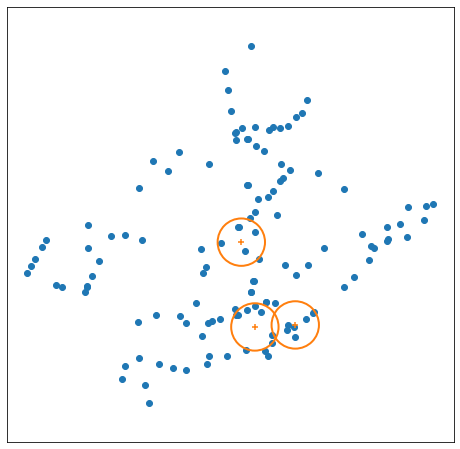

In [87]:
plot_result(points, opts_sites, 0.0027)